In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import time

# Enthusiast Team: Datathon Case
## Predicting Cryptocurrency prices

## Reading the Currencies for the First Problem

In [2]:
currency_info = pd.read_csv("currencies.txt", sep = "\t")
currency_info

,Currency,ticker,CoinID
0,Bitcoin,BTC,1442
1,Bitcoin Cash,BCH,1445
2,Bitcoin Gold,BTG,1456
3,Cardano,ADA,1446
4,Dash,DASH,1453
5,Dogecoin,DOGE,1477
6,Eos,EOS,1452
7,Ethereum,ETH,1443
8,Ethereum Classic,ETC,1457
9,Iota,MIOTA,1451


We need to read the data file for every coin. For easier work, we're going to save them in a dictionary (keys - coin IDs, values - cleaned datasets).

## Data Cleaning
The data is relatively clean but we still need to do some things. For one, we need to parse the dates (so we can use then properly with `numpy`, `pandas` and other libraries) and set the index of the dataframe to be the dates. We also need to remove the `Unnamed: 0` and `refID_coin` as they don't mean anything (they're just indices).

In [3]:
coin_infos = {}
for coin_id in currency_info.CoinID:
    coin_file = "datathon_csv/price_data{0}.csv".format(coin_id)
    coin_info = pd.read_csv(coin_file)
    coin_info.time = pd.to_datetime(coin_info.time)
    coin_info = coin_info.set_index(coin_info.time)
    coin_info = coin_info.drop(["Unnamed: 0", "refID_coin", "time"], axis = 1)
    coin_infos[coin_id] = coin_info

There are many missing dates in the data. Our hypothesis is that our models will need to get data in regular intervals to make their work easier.

To do this, we'll try to get all possible intervals from the beginning to the end.

In [4]:
all_dates = pd.date_range(start = "2018/01/17 11:25:00", end = "2018/03/23 13:15:00", freq = "5Min")

For every coin, we'll see which timestamps are missing and we'll fill them in with the last known value.

Actually, we'll need a bit better handling of movements (1h and 24h) - possibly computing them instead of replacing them with random values. However, we're going to leave this topic for a future time.

In [5]:
for coin_id, coin_data in coin_infos.items():
    missing_dates = np.setdiff1d(all_dates, coin_data.index)
    new_df = pd.DataFrame(index = missing_dates, columns = coin_data.columns)
    new_df = pd.concat([coin_data, new_df]).sort_index().ffill()
    new_df = new_df[~new_df.index.duplicated(keep = "first")]
    coin_infos[coin_id] = new_df

Now we've got a full dataset for all coins. We can save them for later work.

In [6]:
for coin_id, coin_data in coin_infos.items():
    print(coin_id, len(coin_data))
    coin_data.to_csv("clean_data_csv/{0}.csv".format(coin_id))

1442 18750
1445 18750
1456 18750
1446 18750
1453 18750
1477 18750
1452 18750
1443 18750
1457 18750
1451 18750
1460 18750
1448 18750
1454 18750
1447 18750
1449 18750
1444 18750
1450 18750
1474 18750
1455 18750
1465 18750


## Metrics

In [7]:
def MAPE(predicted, actual):
    """
    Mean absolute error, in percentage
    """
    assert len(predicted) == len(actual)
    return np.mean((predicted - actual) / actual) * 100

def DS(predicted, actual):
    return np.mean(np.diff(predicted) * np.diff(actual) > 0) * 100

## Historical simulation

Seasonal decomposition seems to give pretty good results. Since ARIMA models on the residuals give algebraic errors, it's safest to ignore them as a first assumption.

In [8]:
predicted = np.random.random(size = 1000)
actual = np.random.random(size = 1000)


In [9]:
# Directional symmetry
DS(predicted, actual)

56.35635635635635

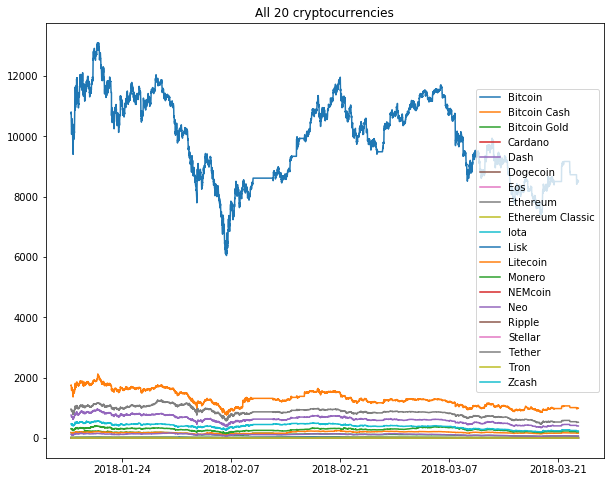

In [10]:
plt.figure(figsize = (10, 8))
for coin_id, coin_data in coin_infos.items():
    plt.plot(coin_infos[coin_id].index, coin_infos[coin_id].price, label = currency_info[currency_info.CoinID == coin_id].Currency.values[0])
    plt.legend(loc = "right")
plt.title("All 20 cryptocurrencies")
plt.show()

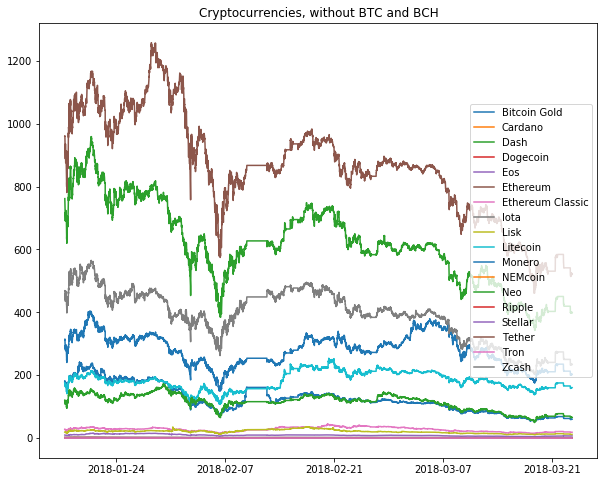

In [11]:
plt.figure(figsize = (10, 8))
for coin_id, coin_data in coin_infos.items():
    # Exclude Bitcoin and Bitcoin Cash
    if coin_id == 1442 or coin_id == 1445:
        continue
        
    plt.plot(coin_infos[coin_id].index, coin_infos[coin_id].price, label = currency_info[currency_info.CoinID == coin_id].Currency.values[0])
    plt.legend(loc = "right")
plt.title("Cryptocurrencies, without BTC and BCH")
plt.show()

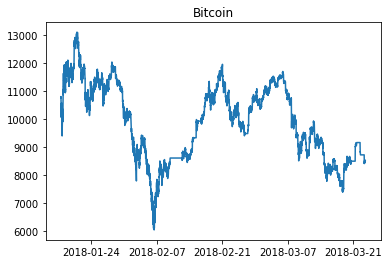

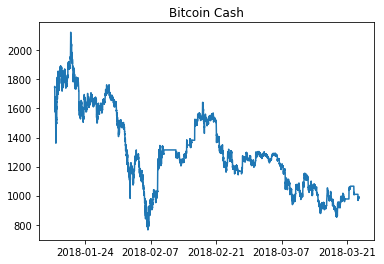

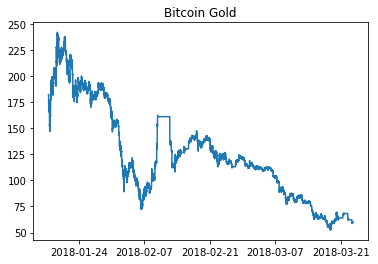

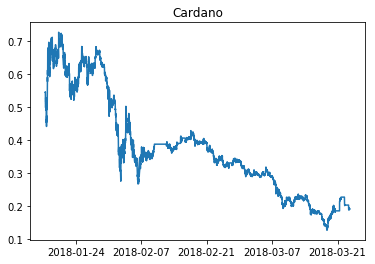

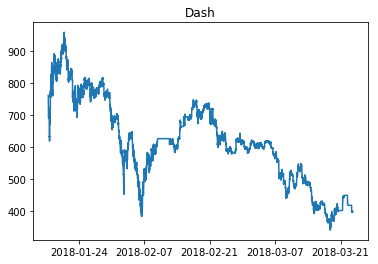

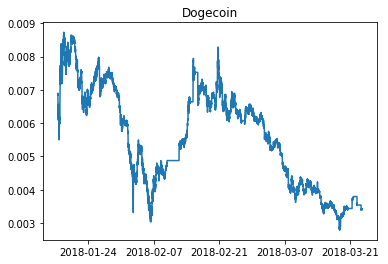

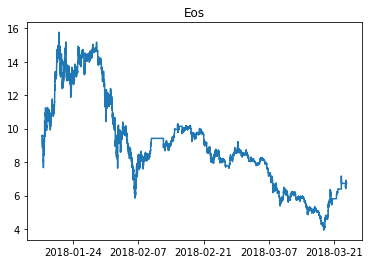

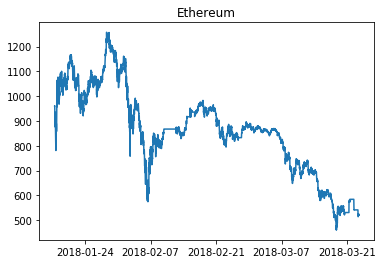

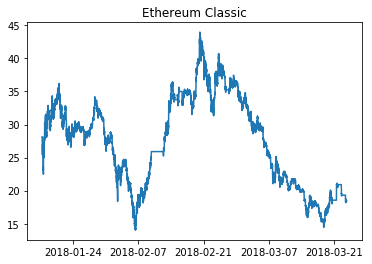

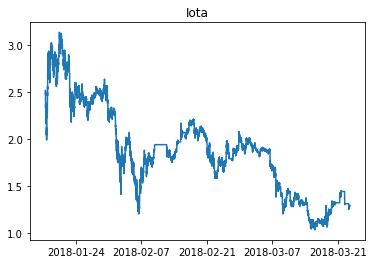

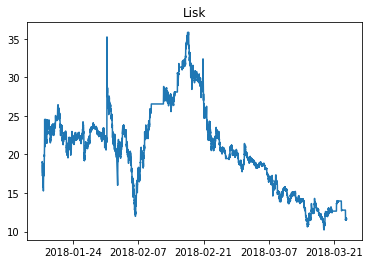

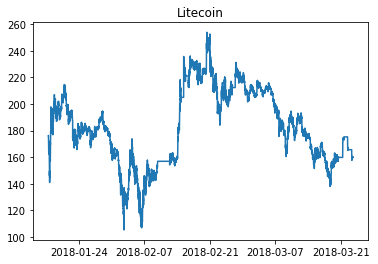

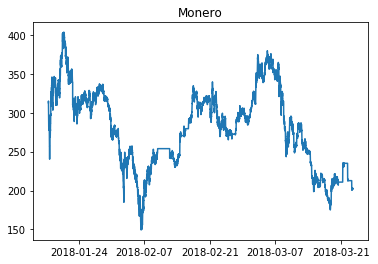

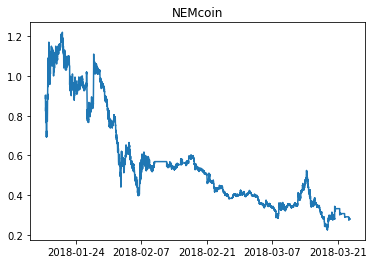

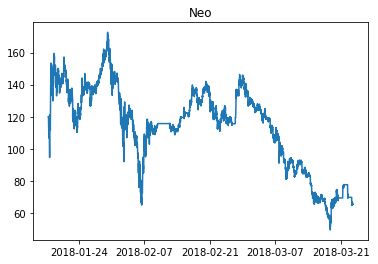

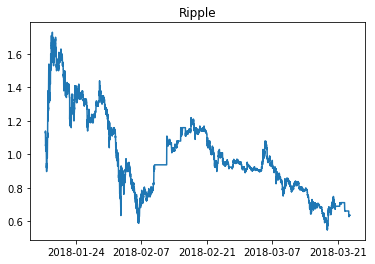

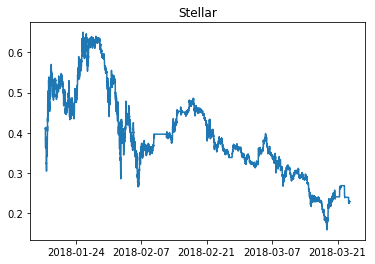

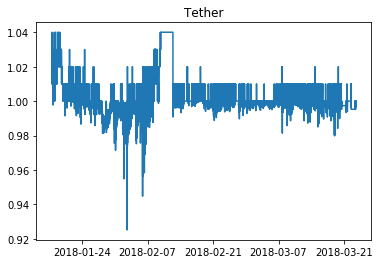

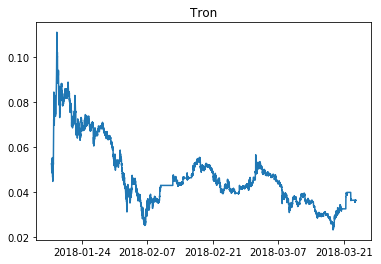

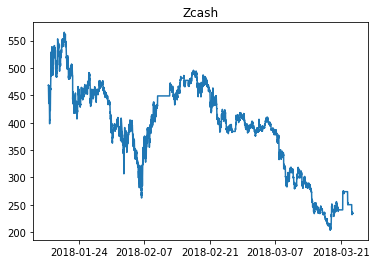

In [12]:
for coin_id, coin_data in coin_infos.items():
    plt.plot(coin_infos[coin_id].index.values, coin_infos[coin_id].price)
    #plt.legend(loc = "right")
    plt.title(currency_info[currency_info.CoinID == coin_id].Currency.values[0])
    plt.show()

## Performing Simulations and Preparing Output

In [13]:
start_date = pd.to_datetime("2018-01-25 00:00:00")

In [ ]:
num_simulations = len(coin_infos[1442][start_date:])
for coin_id, coin_data in coin_infos.items():
    week_ago = pd.to_datetime(start_date) + pd.Timedelta(weeks = -1)
    now = pd.to_datetime(start_date) + pd.Timedelta(minutes = -5)
    predicted_prices, times = [], []    
    for P in range(num_simulations):
        time_delta = 12 # 1 hour
        data_week = coin_data[(coin_data.index >= week_ago) & (coin_data.index < now)]
        initial_time = time.time()
        decomposition = seasonal_decompose(data_week.price, model = "multiplicative", freq = time_delta, two_sided = False)
        trend, seasonal, residual = decomposition.trend, decomposition.seasonal, decomposition.resid
        final_time = time.time()
        predicted_price = trend[-time_delta:].mean() * seasonal[-time_delta]
        predicted_prices.append(predicted_price)
        times.append(final_time - initial_time)
        
        week_ago = week_ago + pd.Timedelta(minutes = 5)
        now = now + pd.Timedelta(minutes = 5)        
    pd.DataFrame(
        data = {
            "prices": predicted_prices, 
            "time": times
        }, index = coin_infos[coin_id][start_date:].index).to_csv("results/{0}.csv".format(coin_id))

A quick inspection shows us that although there's much to be desired, we're not too far away from what the expected results are.

In [ ]:
for coin_id, coin_data in coin_infos.items():
    predictions = pd.read_csv("results/{0}.csv".format(coin_id))
    predictions["Unnamed: 0"] = pd.to_datetime(predictions["Unnamed: 0"])
    predictions.set_index("Unnamed: 0")
    plt.plot(range(len(predictions.prices)), predictions.prices)
    plt.plot(range(len(predictions.prices)), coin_data[coin_data.index >= start_date].price, alpha = 0.8)
    plt.xlabel("Period (relative to 25/01/2018)")
    plt.ylabel("Price")
    currency_name = currency_info[currency_info.CoinID == coin_id].Currency.values[0]
    plt.title(currency_name)
    plt.show()

In [ ]:
# Scoring

start_dates = [
    "2018-02-02 10:00:00",
    "2018-02-10 10:00:00",
    "2018-02-12 10:00:00",
    "2018-02-23 11:00:00",
    "2018-02-15 12:35:00"
]
for coin_id, coin_data in coin_infos.items():
    for i, start_date in enumerate(start_dates):
        now = pd.to_datetime(start_date)
        predictions = pd.read_csv("results/{0}.csv".format(coin_id))
        predictions["Unnamed: 0"] = pd.to_datetime(predictions["Unnamed: 0"])
        predictions = predictions.set_index("Unnamed: 0")
        predictions = predictions[(predictions.index >= now) & (predictions.index < (now + pd.Timedelta(days = 1)))]
        predictions.to_csv("datathon_output/{0}_{1}.csv".format(coin_id, (i + 1)), index = False, columns = ["prices"], header = None)